In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
import numpy as np

In [2]:
image_directory = "DATA/"

In [3]:
def process(data):
  path = pathlib.Path(data)
  filepaths=list(path.glob(r"*/*.*"))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df=pd.concat([df1, df2],axis=1)
  return df

# memasukkan dataframe home ke dalam variabel df_root
df_root= process(image_directory)

os.listdir(image_directory)

['apple',
 'bakso',
 'banana',
 'chicken_wings',
 'churros',
 'cup_cakes',
 'donuts',
 'eggplant',
 'french_fries',
 'fried_rice',
 'gado_gado',
 'gudeg',
 'gyoza',
 'hamburger',
 'ice_cream',
 'kue_cokelat',
 'lumpia',
 'omelette',
 'pempek',
 'pizza',
 'rendang',
 'sate',
 'soto',
 'steak',
 'sushi']

In [4]:
df_root

filepaths labels
0         DATA\apple\0.jpg  apple
1        DATA\apple\10.jpg  apple
2      DATA\apple\1002.jpg  apple
3      DATA\apple\1003.jpg  apple
4       DATA\apple\101.jpg  apple
...                    ...    ...
5595  DATA\sushi\93876.jpg  sushi
5596  DATA\sushi\94385.jpg  sushi
5597  DATA\sushi\96293.jpg  sushi
5598  DATA\sushi\96680.jpg  sushi
5599  DATA\sushi\99997.jpg  sushi

[5600 rows x 2 columns]

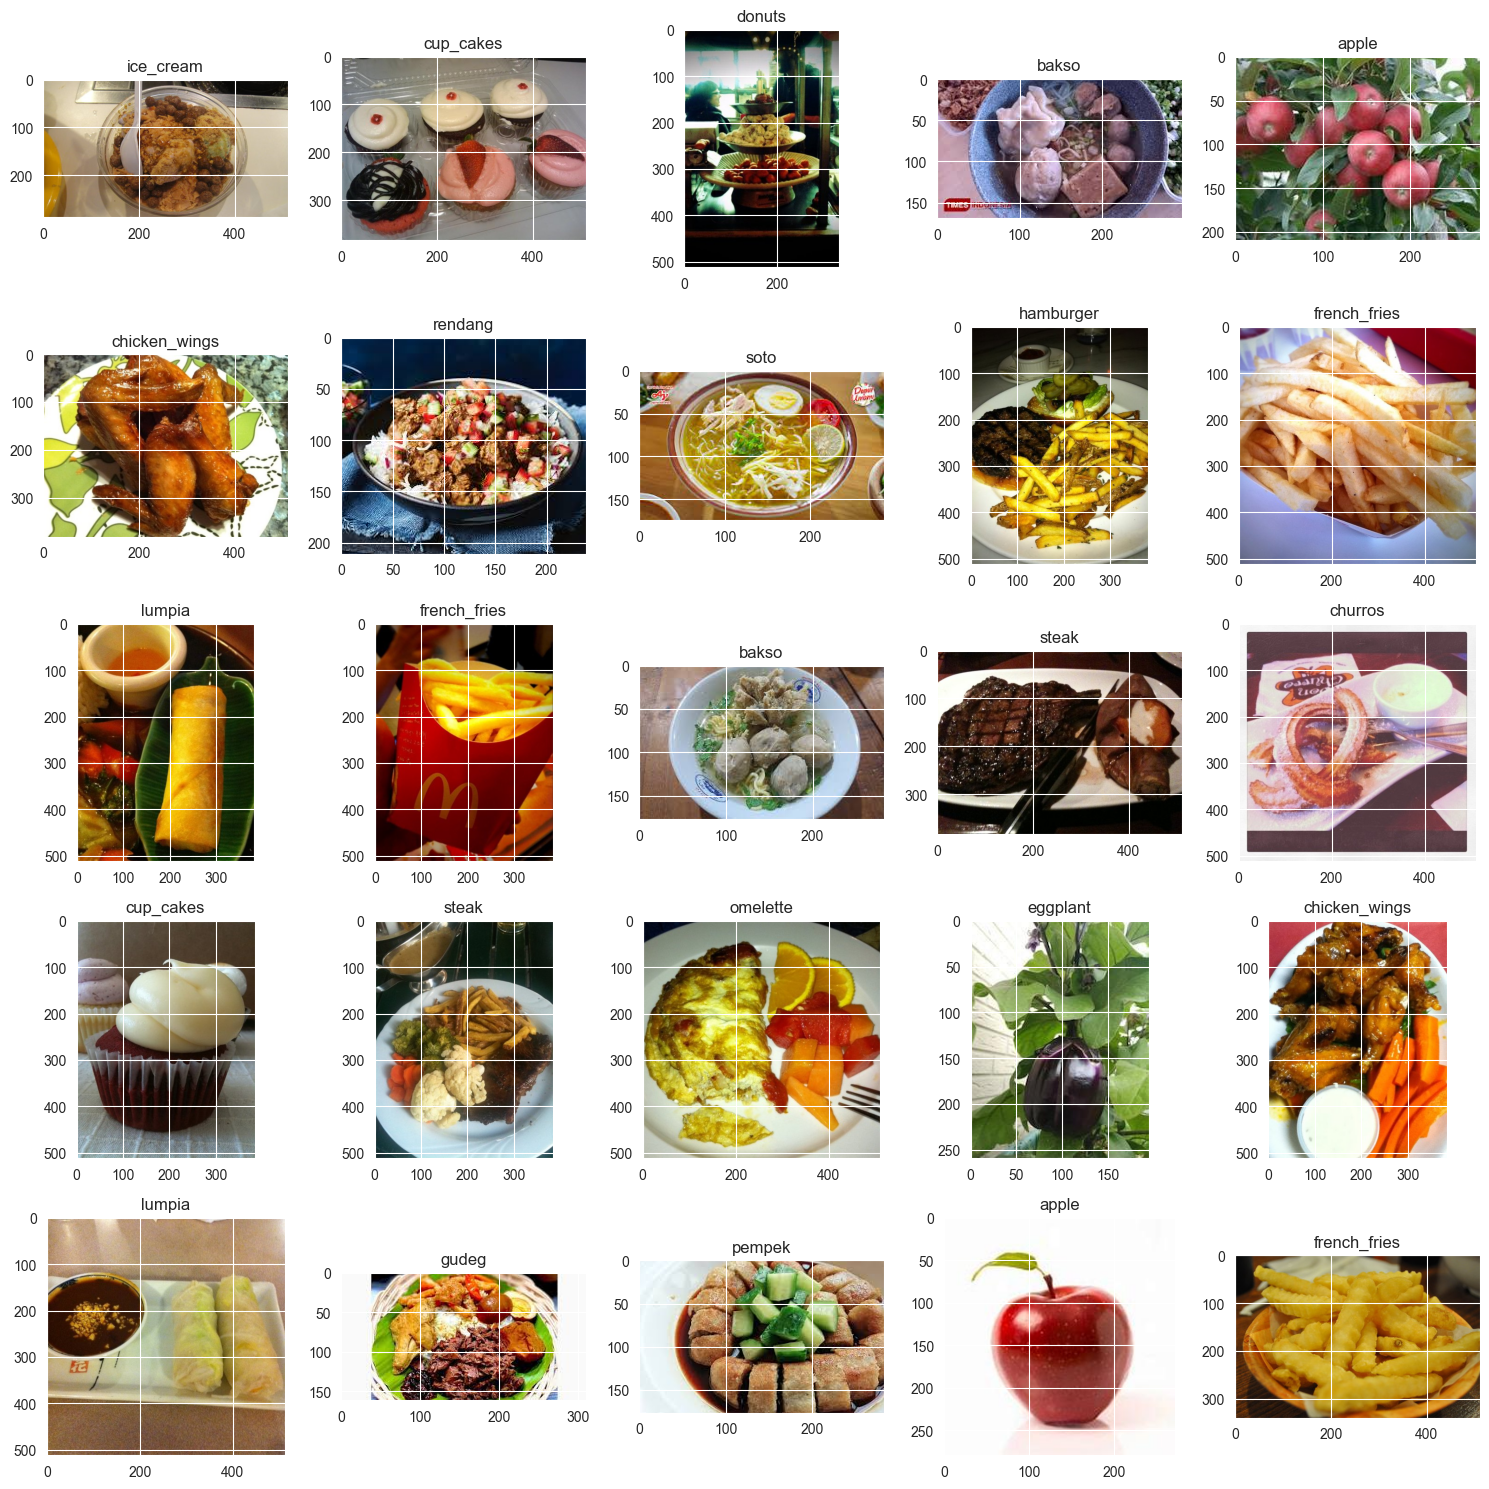

In [5]:
df_root = df_root.sample(frac=1).reset_index(drop=True)
fig, axes=plt.subplots(nrows=5,ncols=5,figsize=(15,15))

for i,ax in enumerate(axes.flat):
  x=plt.imread(df_root['filepaths'][i])
  ax.imshow(x)
  ax.set_title(df_root['labels'][i])
plt.tight_layout()
plt.show()

In [6]:
# Dataset split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_root, test_size=0.25, shuffle=True, random_state=1)
test_df, validation_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=1)

In [7]:
train_df

filepaths     labels
3285  DATA\gado_gado\pic_241.jpg  gado_gado
1751       DATA\sushi\465380.jpg      sushi
4430       DATA\eggplant\236.jpg   eggplant
1380           DATA\apple\79.jpg      apple
2722       DATA\sate\pic_273.jpg       sate
...                          ...        ...
905       DATA\donuts\518995.jpg     donuts
5192       DATA\gyoza\310165.jpg      gyoza
3980   DATA\hamburger\423924.jpg  hamburger
235        DATA\gyoza\384447.jpg      gyoza
5157        DATA\gyoza\78536.jpg      gyoza

[4200 rows x 2 columns]

In [28]:
image_width = 224
image_height = 224

image_dir = 'C:/Users/LENOVO/PycharmProjects/UhuyDevML/DATA'

training_datagen = ImageDataGenerator(rescale=1/255,
                                      horizontal_flip=True,
                                      zoom_range=0.2,
                                      fill_mode='nearest',
                                      shear_range=0.2)
val_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

# Make sure you used "categorical"
train_generator= training_datagen.flow_from_dataframe(dataframe = train_df,
                                                      target_size=(image_width,image_height),
                                                      x_col='filepaths',
                                                      y_col='labels',
                                                      batch_size=32,
                                                      class_mode='categorical')

validation_generator= val_datagen.flow_from_dataframe(dataframe = validation_df,
                                                      target_size=(image_width,image_height),
                                                      x_col='filepaths',
                                                      y_col='labels',
                                                      batch_size=32,
                                                      class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                                  target_size=(image_width,image_height),
                                                  x_col='filepaths',
                                                  y_col='labels',
                                                  batch_size=len(test_df),
                                                  shuffle=True,
                                                  class_mode='categorical')

Found 4200 validated image filenames belonging to 25 classes.
Found 700 validated image filenames belonging to 25 classes.
Found 700 validated image filenames belonging to 25 classes.


In [17]:
from keras.layers import Input

model = tf.keras.applications.MobileNetV2(weights="imagenet",
                                          include_top=False,
                                          input_tensor=Input(shape=(224, 224, 3)))


for layer in model.layers:
    layer.trainable = False

last_output = model.output

In [18]:
inputs = model.input
x = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(25, activation="softmax")(x)

model = tf.keras.models.Model(model.input, x)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [19]:
callback_es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Ubah monitor ke 'val_loss' agar early stopping berdasarkan validation loss
    restore_best_weights=True,
    patience=10
)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks= callback_es,
                    verbose=1)

Epoch 1/50
132/132 [==============================] - 75s 552ms/step - loss: 2.7738 - accuracy: 0.2129 - val_loss: 1.6858 - val_accuracy: 0.5571
Epoch 2/50
132/132 [==============================] - 64s 483ms/step - loss: 1.9359 - accuracy: 0.4164 - val_loss: 1.3111 - val_accuracy: 0.6257
Epoch 3/50
132/132 [==============================] - 64s 483ms/step - loss: 1.6791 - accuracy: 0.4940 - val_loss: 1.0735 - val_accuracy: 0.6814
Epoch 4/50
132/132 [==============================] - 64s 486ms/step - loss: 1.5026 - accuracy: 0.5395 - val_loss: 0.9693 - val_accuracy: 0.7186
Epoch 5/50
132/132 [==============================] - 64s 487ms/step - loss: 1.3522 - accuracy: 0.5869 - val_loss: 0.9984 - val_accuracy: 0.7343
Epoch 6/50
132/132 [==============================] - 66s 500ms/step - loss: 1.2756 - accuracy: 0.6124 - val_loss: 0.9509 - val_accuracy: 0.7129
Epoch 7/50
132/132 [==============================] - 66s 496ms/step - loss: 1.2137 - accuracy: 0.6248 - val_loss: 0.8832 - val_ac

In [26]:
model.save("Foodricion_model.h5")

C:\Users\LENOVO\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


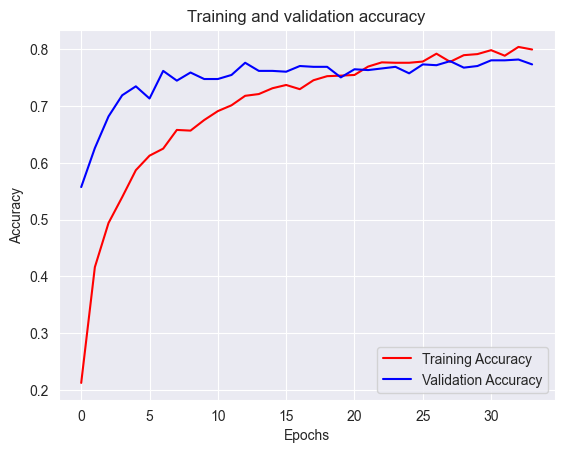

<Figure size 640x480 with 0 Axes>

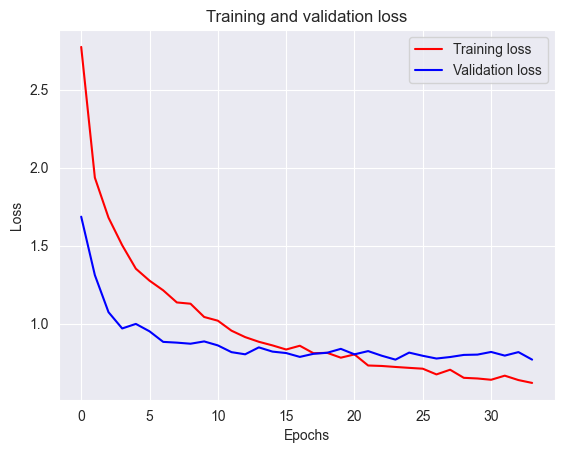

<Figure size 640x480 with 0 Axes>

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Membuat grafik plot untuk accuracy
plt.plot(epochs, acc, 'r', label ='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Membuat grafik plot untuk loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [21]:
results = model.evaluate(test_generator, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

1/1 [==============================] - 12s 12s/step - loss: 0.8720 - accuracy: 0.7686
    Test Loss: 0.87203
Test Accuracy: 76.86%


In [22]:
model.evaluate(train_generator)

132/132 [==============================] - 51s 382ms/step - loss: 0.2673 - accuracy: 0.9376


[0.2672865688800812, 0.9376190304756165]

In [23]:
model.evaluate(test_generator)

1/1 [==============================] - 7s 7s/step - loss: 0.8720 - accuracy: 0.7686


[0.8720287084579468, 0.7685714364051819]

22/22 [==============================] - 6s 284ms/step


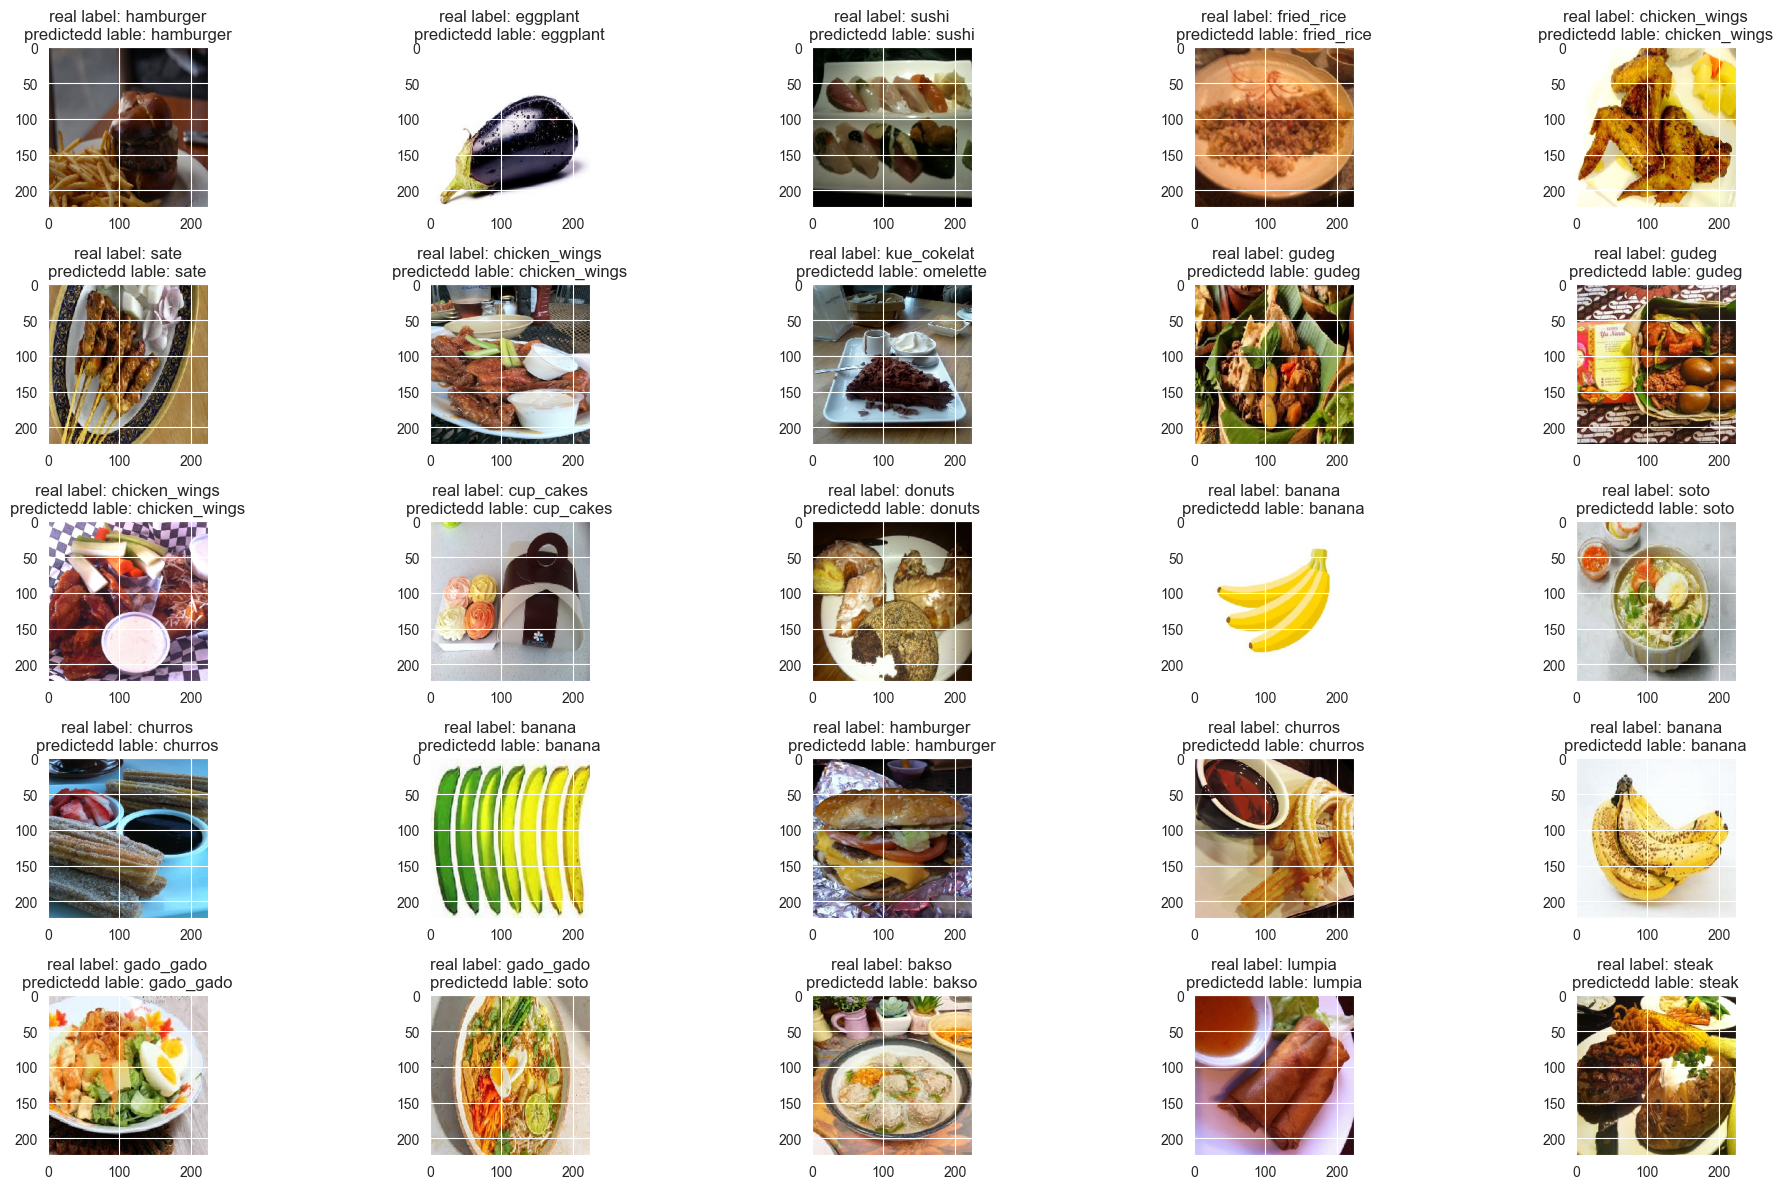

In [29]:
classes = ['apple', 'bakso', 'banana',
 'chicken_wings',
 'churros',
 'cup_cakes',
 'donuts',
 'eggplant',
 'french_fries',
 'fried_rice',
 'gado_gado',
 'gudeg',
 'gyoza',
 'hamburger',
 'ice_cream',
 'kue_cokelat',
 'lumpia',
 'omelette',
 'pempek',
 'pizza',
 'rendang',
 'sate',
 'soto',
 'steak',
 'sushi']
images, labels = test_generator.next()
preds = model.predict(images)
fig,axes=plt.subplots(nrows=5,ncols=5,figsize=(20,12))
dic={i:ax for i,ax in enumerate(axes.flat)}
for i in range(0,25):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title("real label: " + str(classes[label]) + "\n" + "predictedd lable: " + str(classes[pred]))
    dic[i].imshow(image)
plt.tight_layout()
plt.show()

22/22 [==============================] - 6s 287ms/step - loss: 0.8720 - accuracy: 0.7686
Loss of the model is -  0.8720288276672363
Accuracy of the model is -  76.85714364051819 %
22/22 [==============================] - 6s 292ms/step
               precision    recall  f1-score   support

        apple       1.00      0.90      0.95        21
        bakso       0.90      0.71      0.79        38
       banana       1.00      1.00      1.00        29
chicken_wings       0.67      0.95      0.78        21
      churros       0.85      0.65      0.74        26
    cup_cakes       0.72      0.84      0.78        31
       donuts       0.61      0.72      0.66        32
     eggplant       0.94      0.97      0.95        30
 french_fries       0.81      0.81      0.81        27
   fried_rice       0.65      0.91      0.75        22
    gado_gado       0.77      0.71      0.74        28
        gudeg       0.77      0.79      0.78        38
        gyoza       0.78      0.64      0.71     

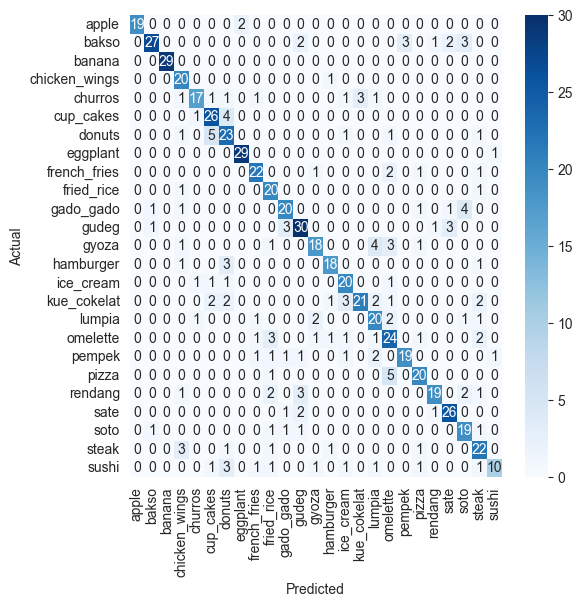

In [25]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_generator, class_names):
    test_images, test_labels = test_generator.next()
    # Evaluasi model dan cetak loss serta akurasi
    loss, accuracy = model.evaluate(test_images, test_labels)
    print('Loss of the model is - ', loss)
    print('Accuracy of the model is - ', accuracy * 100, '%')

    # Prediksi kelas
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Laporan klasifikasi
    print(classification_report(np.argmax(test_labels, axis=1), predicted_classes, target_names=class_names))

    # Matriks konfusi
    conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_classes)

    # Plot matriks konfusi
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(6, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

class_names = ['apple', 'bakso', 'banana',
 'chicken_wings',
 'churros',
 'cup_cakes',
 'donuts',
 'eggplant',
 'french_fries',
 'fried_rice',
 'gado_gado',
 'gudeg',
 'gyoza',
 'hamburger',
 'ice_cream',
 'kue_cokelat',
 'lumpia',
 'omelette',
 'pempek',
 'pizza',
 'rendang',
 'sate',
 'soto',
 'steak',
 'sushi']

evaluate_model(model, test_generator, class_names)